# Hotel Reservation Cancellation Analysis - Data Cleaning & EDA

This is the first notebook in the _Hotel Reservation Cancellation Analysis_ project. 
<br>

The main question we are asking: how accurately can we predict if a guest is going to cancel the reservation at a hotel. The business case is clear: roughly 25% of the hotel guests cancelled their reservations. If we could build a model that accurately predict, that would potentially increase the accuracy of any financial forecasting the hotel is carrying out. 
<br>

The database is from this article: https://www.sciencedirect.com/science/article/pii/S2352340918315191#!, the authors collected guest information for two hotels between 2015 and 2017, along with whether the reservation was eventually cancelled or not. Please refer to the link for a very detailed data dictionary. For more background information on the project, please refer to the `README.md` file. 
<br>

We randomly selected `H1`, the first hotel, to use in the modelling. A similar analysis could be carried out on the other hotel, `H2`. At the end of the project we will do a bonus line of testing on the set aside `H2` dataset to analyse if the underlying pattern we observe on one hotel can be transferred to a different one. 

In this notebook, the goal is to import the original dataset, and:
- search for erronous-looking data inputs and handle them;
- apply any necessary re-coding or data manipulation;
- identify limitations of the dataset;
- prepare some preliminary EDA before the modelling happens (in the second notebook).

## Setting up the Database

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

import datacleaning_func

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('H1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
IsCanceled                     40060 non-null int64
LeadTime                       40060 non-null int64
ArrivalDateYear                40060 non-null int64
ArrivalDateMonth               40060 non-null object
ArrivalDateWeekNumber          40060 non-null int64
ArrivalDateDayOfMonth          40060 non-null int64
StaysInWeekendNights           40060 non-null int64
StaysInWeekNights              40060 non-null int64
Adults                         40060 non-null int64
Children                       40060 non-null int64
Babies                         40060 non-null int64
Meal                           40060 non-null object
Country                        39596 non-null object
MarketSegment                  40060 non-null object
DistributionChannel            40060 non-null object
IsRepeatedGuest                40060 non-null int64
PreviousCancellations          40060 non-null int64
Pr

At a first glance, database looks clean, the categories are correct with the exception of `ReservationStatusDate`, the only visible missing value is in the `Country` column. 
<br>

In the following, we are checking the database column by column, starting with the categorical variables. 

## Data Cleaning - Categorical Variables

We have 13 categorical variables in the data: `ArrivalDateMonth`, `Meal`, `Country`, `MarketSegment`, `DistributionChannel`, `ReservedRoomType`, `AssignedRoomType`, `DepositType`, `Agent`, `Company`, `CustomerType`, `ReservationStatus`, `ReservationStatusDate`. The date field at the end is not properly encoded as a `datedime` object, we are handling it in this section. 
<br>

In the following, we are first analysing the columns one by one, make a decision as to whether we need to apply any changes. Then, we apply the changes grouped at the end, so it's easy to see what happened at a glance. 

### Analysis

In [5]:
df['ArrivalDateMonth'].value_counts()

August       4894
July         4573
April        3609
May          3559
October      3555
March        3336
September    3108
February     3103
June         3045
December     2648
November     2437
January      2193
Name: ArrivalDateMonth, dtype: int64

It would make sense to decode the months as numbers, so a decision tree can essentially split up the year without having to create dummy variables. 

In [6]:
df['Meal'].value_counts()

BB           30005
HB            8046
Undefined     1169
FB             754
SC              86
Name: Meal, dtype: int64

The `Meal` variable is OK, but we will need dummies at the end. 

In [7]:
df['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
SYR        1
SAU        1
TGO        1
FJI        1
UZB        1
Name: Country, Length: 125, dtype: int64

This would unnecessarily blow up the calculations. We are re-coding as Portugal, NonPortugal, and Unknown. Checked if all the Unknown are cancelled, but no. 

In [8]:
df['MarketSegment'].value_counts()

Online TA        17729
Offline TA/TO     7472
Direct            6513
Groups            5836
Corporate         2309
Complementary      201
Name: MarketSegment, dtype: int64

This column looks correct, needs dummies. 

In [9]:
df['DistributionChannel'].value_counts()

TA/TO        28925
Direct        7865
Corporate     3269
Undefined        1
Name: DistributionChannel, dtype: int64

Delete one Undefined, and then, dummies. 

In [10]:
df['ReservedRoomType'].value_counts()

A                   23399
D                    7433
E                    4982
G                    1610
F                    1106
C                     918
H                     601
L                       6
B                       3
P                       2
Name: ReservedRoomType, dtype: int64

In [12]:
df['AssignedRoomType'].value_counts()

A                   17046
D                   10339
E                    5638
C                    2214
G                    1853
F                    1733
H                     712
I                     363
B                     159
P                       2
L                       1
Name: AssignedRoomType, dtype: int64

Interesting how there is a discrepancy here, but data dictionary calls the attention to this. Dropping P, L types, otherwise, create dummy. 
Also, create new column boolean, that checks if assigned type = reserved. 

In [13]:
df['DepositType'].value_counts()

No Deposit         38199
Non Refund          1719
Refundable           142
Name: DepositType, dtype: int64

Just needs dummies. 

In [14]:
df['Agent'].value_counts()

        240    13905
       NULL     8209
        250     2869
        241     1721
         40     1002
               ...  
        165        1
        333        1
        335        1
        450        1
        159        1
Name: Agent, Length: 186, dtype: int64

This is too many categories, would make modelling unnecessarily complicated. In the `datacleaning_func` package, we include a method that checks the columns frequencies, and if the corresponding row is from an agent that is below a certain threshold, re-codes it as `Other`, so we will be left with a manageable number of categories where the smaller agents are grouped together. Threshold is 500 as default in the function. 

In [15]:
df['Company'].value_counts()

       NULL    36952
        223      784
        281      138
        154      133
        405      100
               ...  
        407        1
        461        1
        102        1
         10        1
        531        1
Name: Company, Length: 236, dtype: int64

Same treatment as with `Agent` column above, we are recoding the companies with low frequencies. Threshold is different, 100 as default. 

In [16]:
df['CustomerType'].value_counts()

Transient          30209
Transient-Party     7791
Contract            1776
Group                284
Name: CustomerType, dtype: int64

Needs dummies. 

In [17]:
df['ReservationStatus'].value_counts()

Check-Out    28938
Canceled     10831
No-Show        291
Name: ReservationStatus, dtype: int64

We can't use this variable for obvious reasons. Same goes for `ReservationStatusDate`, which is either the date of check-out, or the date when the reservation got cancelled. If it's lower than the reservation date, the reservation got cancelled. 
<br>

It would be interesting to analyse the reservation cancellations from a time series perspective, answering questions like what are the chances of a reservation being cancelled, assuming it hasn't been for x days and we have y days until the reserved date, but it is outside the scope of this project. What we are interested in is if we can predict the cancellation at the time of the reservation. 

### Data Adjustment

In this section, we are applying all the decisions made in the previous section. 

In [4]:
df = datacleaning_func.apply_categorical_datacleaning(df)

## Data Cleaning - Cont. Variables 

We are repeating the analysis structure from above, first, we are looking at the continuous variables column by column, and then we apply all the data cleaning steps at the end, using a method from `datacleaning_func`. 

### Analysis

In [21]:
df.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
count,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000,40051.000000
mean,0.277596,92.693940,2016.121645,6.544456,27.140396,15.822152,1.190008,3.129210,1.867194,0.128686,0.013907,0.044393,0.101720,0.146438,0.288033,0.527877,94.952777,0.138074,0.619860,0.807246
std,0.447819,97.287413,0.722275,3.183210,14.006248,8.884061,1.147826,2.461369,0.697142,0.445220,0.119011,0.205970,1.335257,1.002022,0.726616,7.429411,61.439617,0.351009,0.813945,0.394467
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,2016.000000,4.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,1.000000
50%,0.000000,57.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000,1.000000
75%,1.000000,155.000000,2017.000000,9.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000,1.000000
max,1.000000,737.000000,2017.000000,12.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,30.000000,17.000000,185.000000,508.000000,8.000000,5.000000,1.000000


From left to right, we check data that looks potentially erronous based on the `describe` table above. 

In [30]:
df[df['LeadTime'] > 365]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
1,0,737,2015,7,27,1,0,0,2,0,...,4,No Deposit,Unknown,Unknown,0,Transient,0.00,0,0,1
81,1,368,2015,7,27,3,3,7,2,0,...,0,No Deposit,40,Unknown,0,Contract,55.68,0,0,1
225,0,394,2015,7,28,8,2,5,2,0,...,0,No Deposit,40,Unknown,0,Contract,89.68,0,0,1
245,0,366,2015,7,28,9,2,5,2,0,...,0,No Deposit,40,Unknown,0,Contract,134.73,0,0,1
890,0,460,2015,8,32,3,2,5,1,0,...,0,No Deposit,40,Unknown,0,Contract,77.54,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39536,0,367,2017,8,33,14,2,5,2,0,...,1,No Deposit,240,Unknown,0,Transient,249.23,1,3,1
39868,0,407,2017,8,34,24,2,5,2,0,...,0,No Deposit,243,Unknown,0,Contract,121.50,0,2,1
39869,0,407,2017,8,34,24,2,5,2,0,...,0,No Deposit,243,Unknown,0,Contract,121.50,0,2,1
40033,0,379,2017,8,34,24,4,10,2,0,...,0,No Deposit,243,Unknown,0,Contract,72.20,0,1,1


Long lead times are odd (this is the time difference in days between booking at future arrival), but it does not seem to be an isolated case, 1% of rows are affected. We don't believe this to be a large issue, leaving it in. 

In [39]:
df[df['Adults'] > 4]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
1539,1,304,2015,9,36,3,0,3,40,0,...,0,No Deposit,Unknown,Unknown,0,Group,0.0,0,0,1
1587,1,333,2015,9,36,5,2,5,26,0,...,0,No Deposit,96,Unknown,0,Group,0.0,0,0,1
1643,1,336,2015,9,37,7,1,2,50,0,...,0,No Deposit,Unknown,Unknown,0,Group,0.0,0,0,1
1752,1,340,2015,9,37,12,2,5,26,0,...,0,No Deposit,96,Unknown,0,Group,0.0,0,0,1
1884,1,347,2015,9,38,19,2,5,26,0,...,0,No Deposit,96,Unknown,0,Group,0.0,0,0,1
1917,1,349,2015,9,39,21,1,3,27,0,...,0,No Deposit,Unknown,Unknown,0,Group,0.0,0,0,1
1962,1,352,2015,9,39,24,1,3,27,0,...,0,No Deposit,Unknown,Unknown,0,Group,0.0,0,0,1
2003,1,354,2015,9,39,26,2,5,26,0,...,0,No Deposit,96,Unknown,0,Group,0.0,0,0,1
2164,1,361,2015,10,40,3,2,5,26,0,...,0,No Deposit,96,Unknown,0,Group,0.0,0,0,1
2173,1,338,2015,10,41,4,2,0,55,0,...,0,No Deposit,Unknown,Unknown,0,Group,0.0,0,0,1


These 16 rows, on the other hand, look like issues, and we think it's potentially an issue with the administration system. All grouped in 2015 Sep - Oct. Going to delete these rows from the data. 

In [40]:
df[df['Children'] > 4]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
328,1,55,2015,7,29,12,4,10,2,10,...,2,No Deposit,Other,Unknown,0,Contract,133.16,0,1,1


Same as with adults, this looks odd, we are deleting rows where children > 4. 

In [41]:
df[df['PreviousCancellations'] > 5]['ArrivalDateMonth'].value_counts()

9     82
10    26
7     24
Name: ArrivalDateMonth, dtype: int64

In [42]:
df[df['PreviousCancellations'] > 10]['ArrivalDateMonth'].value_counts()

9     82
10    26
7     24
Name: ArrivalDateMonth, dtype: int64

In [44]:
df[df['PreviousCancellations'] > 10]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
14779,1,275,2015,10,41,4,2,0,2,0,...,0,Non Refund,Other,Unknown,0,Transient,50.0,0,0,1
14780,1,275,2015,10,41,4,2,0,2,0,...,0,Non Refund,Other,Unknown,0,Transient,50.0,0,0,1
14781,1,275,2015,10,41,4,2,0,2,0,...,0,Non Refund,Other,Unknown,0,Transient,50.0,0,0,1
14782,1,275,2015,10,41,4,2,0,2,0,...,0,Non Refund,Other,Unknown,0,Transient,50.0,0,0,1
14783,1,275,2015,10,41,4,2,0,2,0,...,0,Non Refund,Other,Unknown,0,Transient,50.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15169,1,244,2015,9,36,2,2,5,2,0,...,0,No Deposit,96,Unknown,0,Transient-Party,8.0,0,0,1
15170,1,244,2015,9,36,2,2,5,2,0,...,0,No Deposit,96,Unknown,0,Transient-Party,8.0,0,0,1
15171,1,244,2015,9,36,2,2,5,2,0,...,0,No Deposit,96,Unknown,0,Transient-Party,8.0,0,0,1
15172,1,244,2015,9,36,2,2,5,2,0,...,0,No Deposit,96,Unknown,0,Transient-Party,8.0,0,0,1


In [43]:
df[df['PreviousCancellations'] > 1]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
13951,0,4,2015,10,44,30,0,2,2,0,...,1,No Deposit,Unknown,Other,0,Transient,40.0,1,2,0
13952,0,0,2015,12,51,15,0,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,35.0,0,2,1
13953,0,1,2016,1,4,19,0,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,30.0,0,2,0
13954,0,0,2016,6,26,20,1,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,63.0,1,2,0
13955,0,1,2016,11,46,9,0,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,30.0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25712,1,9,2016,11,47,16,0,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,35.0,0,0,1
25713,0,16,2016,11,48,23,0,1,1,0,...,0,No Deposit,Unknown,Other,0,Transient,35.0,0,0,0
25714,0,2,2017,2,5,1,0,1,1,0,...,1,No Deposit,Unknown,Other,0,Transient,35.0,0,0,1
26150,1,1,2017,7,28,11,0,1,2,0,...,0,No Deposit,Unknown,Other,0,Transient,119.7,0,3,1


Something strange is going on here, particularly with the bookings in 2015 Sep - Oct. Only 200 rows out of 40k had a previous cancellation, so it's not a valuable column, and the rows are potentially wrong. So we drop the rows where this is larger than 1, and drop the column. 

In [45]:
df[df['PreviousBookingsNotCanceled'] > 10]['ArrivalDateYear'].value_counts()

2017    48
2016    31
Name: ArrivalDateYear, dtype: int64

Not from the usual erronous 2015 Sep - Oct group, I suppose there could be repeated customers. 

In [46]:
df[df['PreviousBookingsNotCanceled'] > 1]['IsRepeatedGuest'].value_counts()

1    696
0    362
Name: IsRepeatedGuest, dtype: int64

In [47]:
df[df['PreviousBookingsNotCanceled'] == 0]['IsRepeatedGuest'].value_counts()

0    37665
1      355
Name: IsRepeatedGuest, dtype: int64

These should be in line, as in, if somebody is a repeated guest, they should have not cancelled previous bookings. We assume this is an administrative difference between two systems, and will keep the data as it is. 

In [48]:
df[df['ADR'] <= 0]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned
0,0,342,2015,7,27,1,0,0,2,0,...,3,No Deposit,Unknown,Unknown,0,Transient,0.0,0,0,1
1,0,737,2015,7,27,1,0,0,2,0,...,4,No Deposit,Unknown,Unknown,0,Transient,0.0,0,0,1
125,0,32,2015,7,27,4,0,1,4,0,...,2,No Deposit,Unknown,Unknown,0,Transient,0.0,0,1,1
167,0,111,2015,7,28,6,0,0,2,0,...,0,No Deposit,240,Unknown,0,Transient,0.0,0,2,0
168,0,0,2015,7,28,6,0,0,1,0,...,0,No Deposit,250,Unknown,0,Transient,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39427,0,6,2017,8,33,17,0,1,1,0,...,0,No Deposit,Other,Unknown,0,Transient,0.0,0,0,0
39527,0,0,2017,8,34,20,0,0,2,0,...,0,No Deposit,Unknown,Unknown,0,Transient,0.0,1,1,1
39585,0,4,2017,8,34,20,2,0,1,0,...,0,No Deposit,Other,Unknown,0,Transient,0.0,0,1,0
39852,0,0,2017,8,35,30,0,0,2,0,...,0,No Deposit,Other,Unknown,0,Transient,0.0,0,0,1


Too many rows have non-positive price for it to be a mistake. Keeping these in. There is one negative ADR, which we found strange, but will probably just be grouped with the 0's. 

In [56]:
raw_df[raw_df['RequiredCarParkingSpaces'] > 2] 

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
29045,0,26,2017,March,11,14,0,5,2,0,...,No Deposit,NULL,NULL,0,Transient-Party,40.0,8,1,Check-Out,2017-03-19
29046,0,138,2017,March,12,19,2,2,2,0,...,No Deposit,NULL,NULL,122,Transient-Party,80.0,8,0,Check-Out,2017-03-23
38117,0,205,2017,June,26,26,3,10,2,0,...,No Deposit,250,NULL,0,Transient,111.0,3,0,Check-Out,2017-07-09


There are 3 rows with more than 2 parking spaces, which is weird. We are changing them to 2. 

### Data Adjustment

In this section, we are applying all the decisions made in the previous section. 

In [5]:
cont_data_cleaning_results = datacleaning_func.apply_continuous_datacleaning(df)

In [6]:
df = cont_data_cleaning_results[0]

In [7]:
df.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservedTypeEqualsAssigned,StaysInNights
count,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.00000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000,39453.000000
mean,0.276709,92.617900,2016.128279,6.531772,27.085976,15.843358,1.202139,3.160064,1.859402,0.129445,0.014067,0.041746,0.14080,0.288825,0.535878,96.060890,0.139229,0.621778,0.810635,4.362203
std,0.447377,97.008845,0.720490,3.181279,14.000438,8.884917,1.148497,2.456032,0.444619,0.444072,0.119692,0.200010,0.97527,0.726901,7.485219,61.046464,0.348234,0.813368,0.391803,3.374013
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,11.000000,2016.000000,4.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,51.500000,0.000000,0.000000,1.000000,2.000000
50%,0.000000,58.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,76.000000,0.000000,0.000000,1.000000,4.000000
75%,1.000000,154.000000,2017.000000,9.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,7.000000
max,1.000000,709.000000,2017.000000,12.000000,53.000000,31.000000,19.000000,50.000000,4.000000,3.000000,2.000000,1.000000,30.00000,17.000000,185.000000,508.000000,2.000000,5.000000,1.000000,69.000000


Checking the number of rows deleted for each step.

In [8]:
deleted_row_dict = cont_data_cleaning_results[1]

In [9]:
for column in deleted_row_dict.keys():
    print("Deleted rows due to column '" + column + "': " + str(deleted_row_dict[column]))

Deleted rows due to column 'Adults': 16
Deleted rows due to column 'Children': 1
Deleted rows due to column 'PreviousCancellations': 199
Deleted rows due to column 'StaysInNights': 382


## Data Cleaning - Summary

re-coded category, deleted wrong / outlier continuous, 


Saving the database as `H1_clean.csv`, this can be the input of the modelling later. 

In [15]:
df.to_csv('H1_clean.csv', index = False)

## EDA

In this section, we are plotting charts on the cleaned dataset. 

In [3]:
df = pd.read_csv('H1_clean.csv')

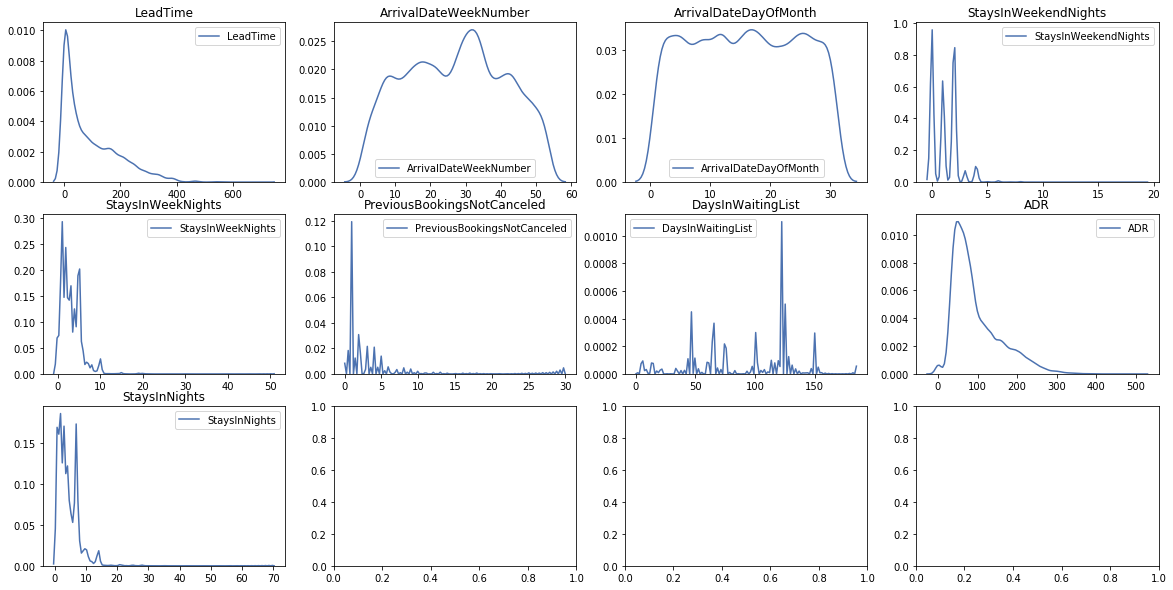

In [3]:
datacleaning_func.plot_dists(df, var_type = 'continuous')

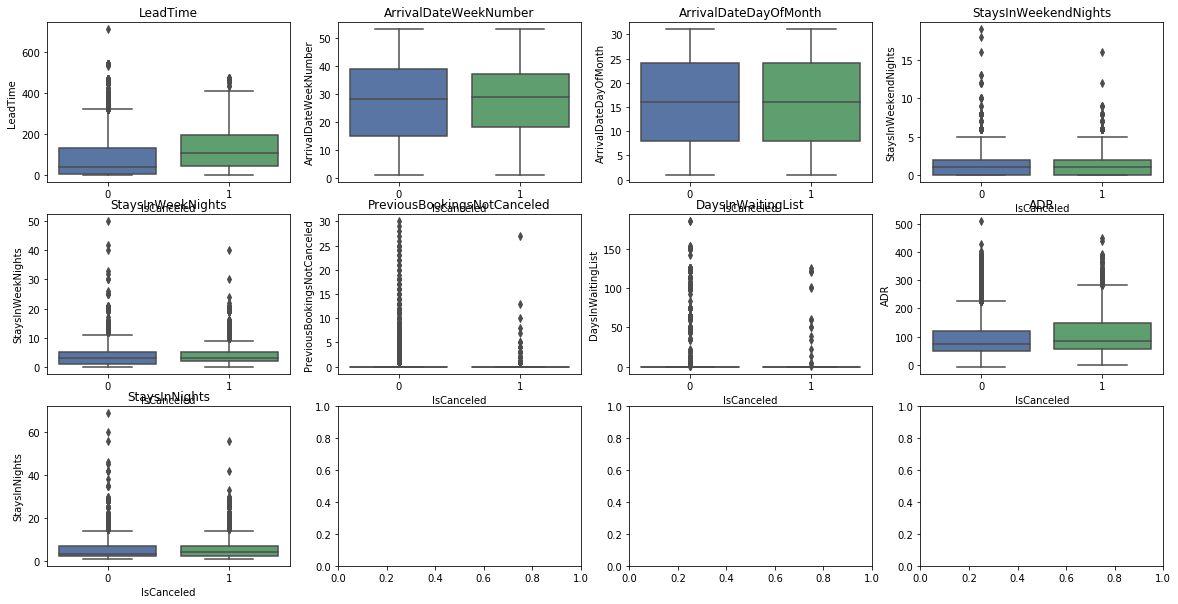

In [5]:
datacleaning_func.plot_dists(df, var_type = 'continuous', target = 'IsCanceled')

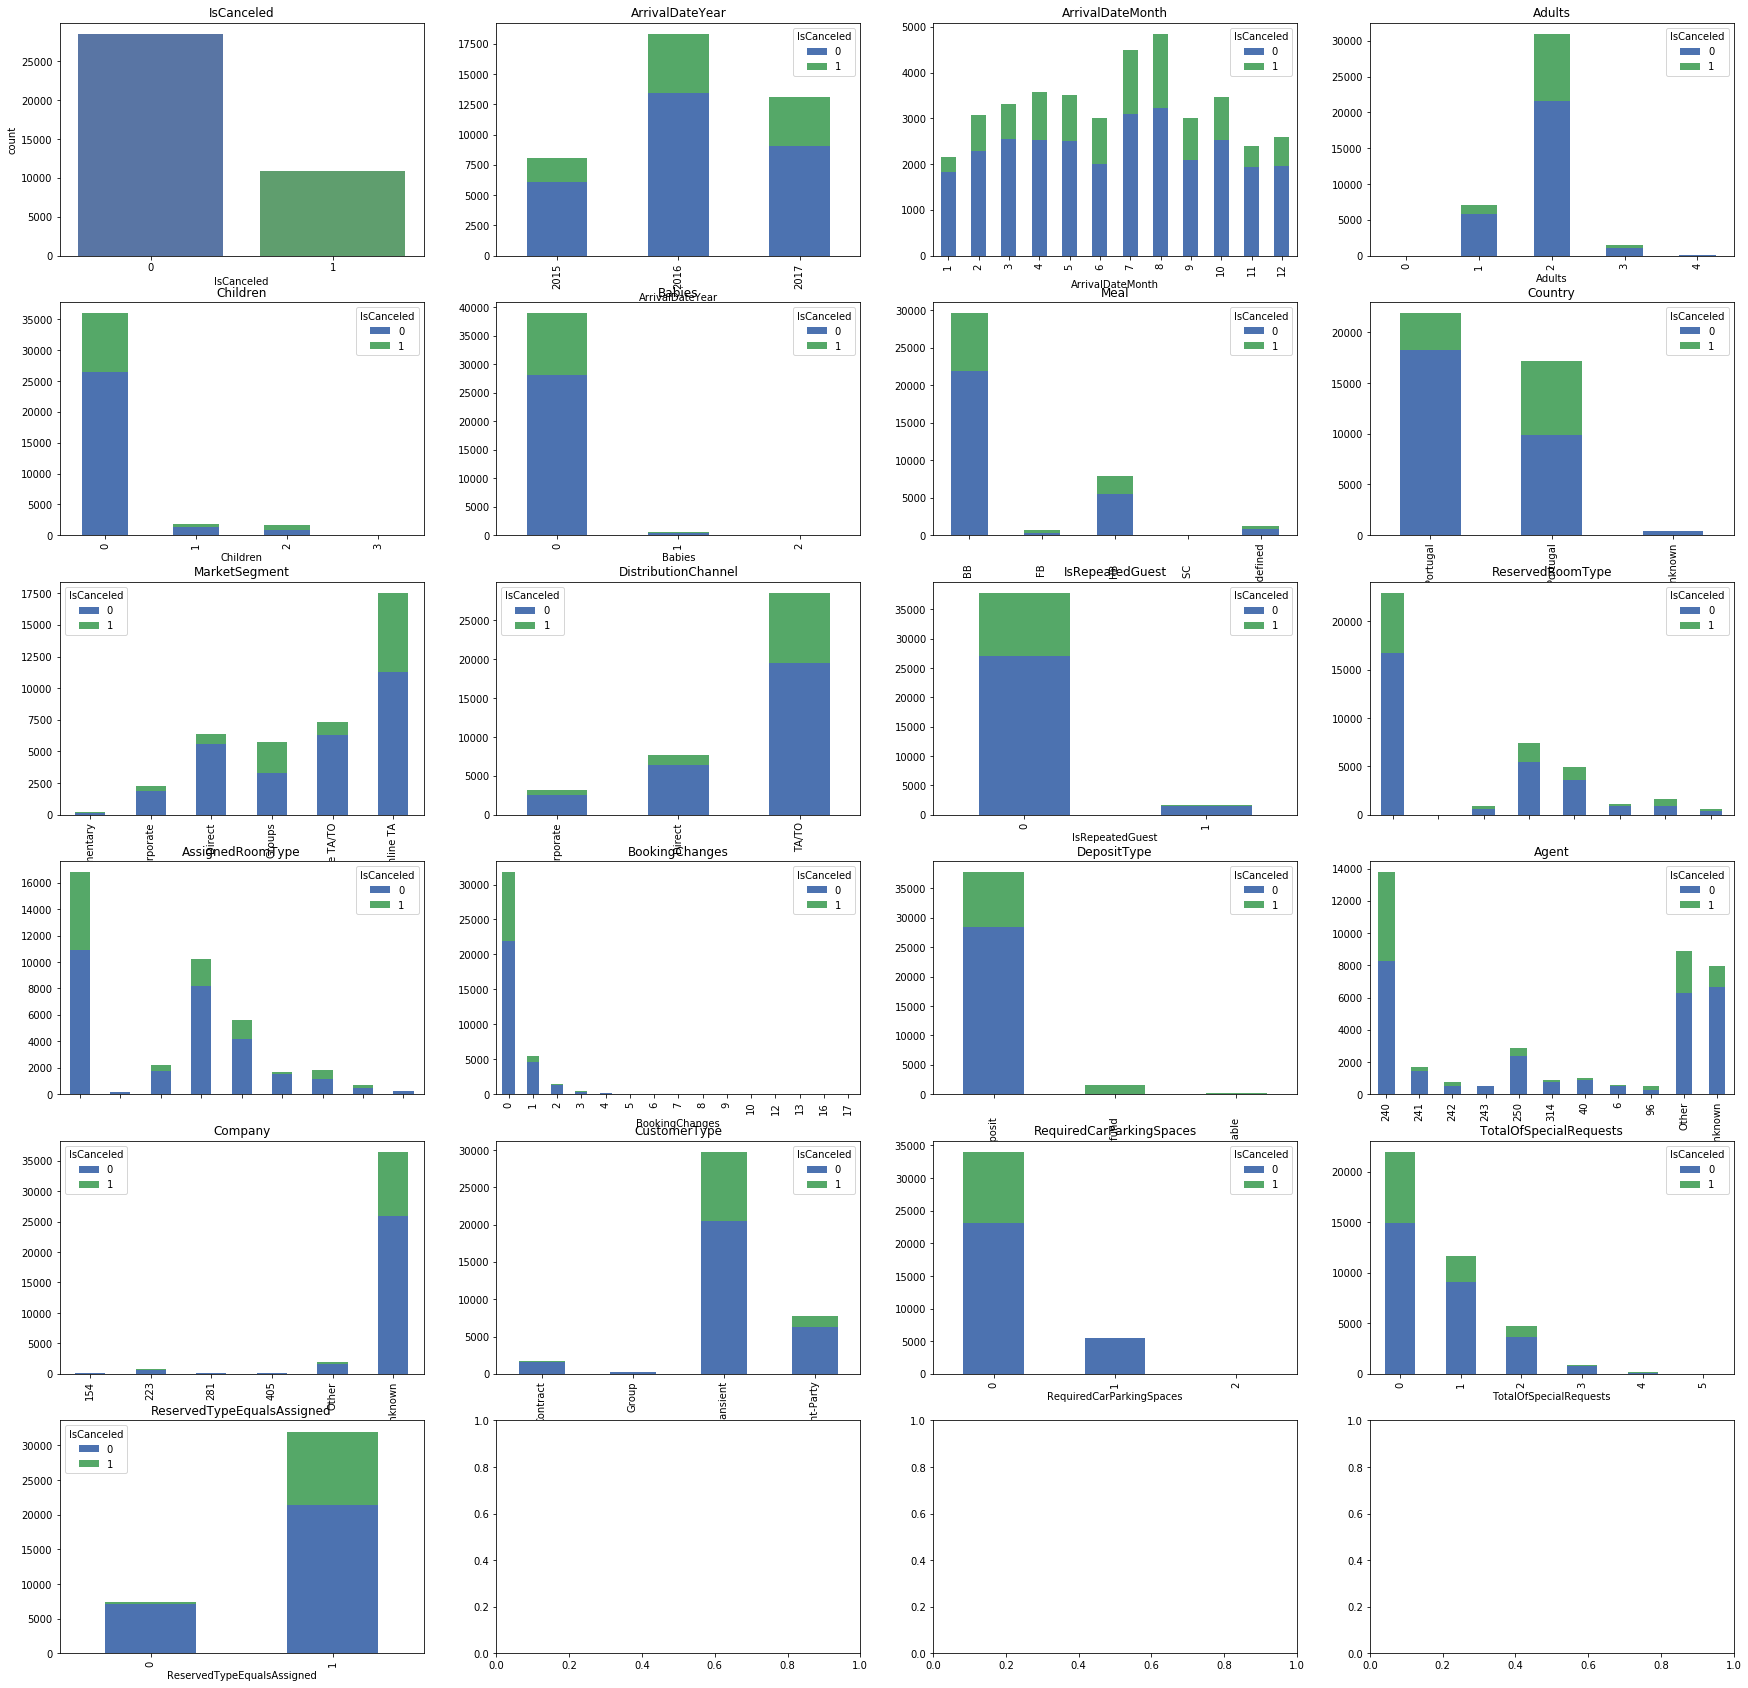

In [6]:
datacleaning_func.plot_dists(df, var_type = 'categorical', target = 'IsCanceled')

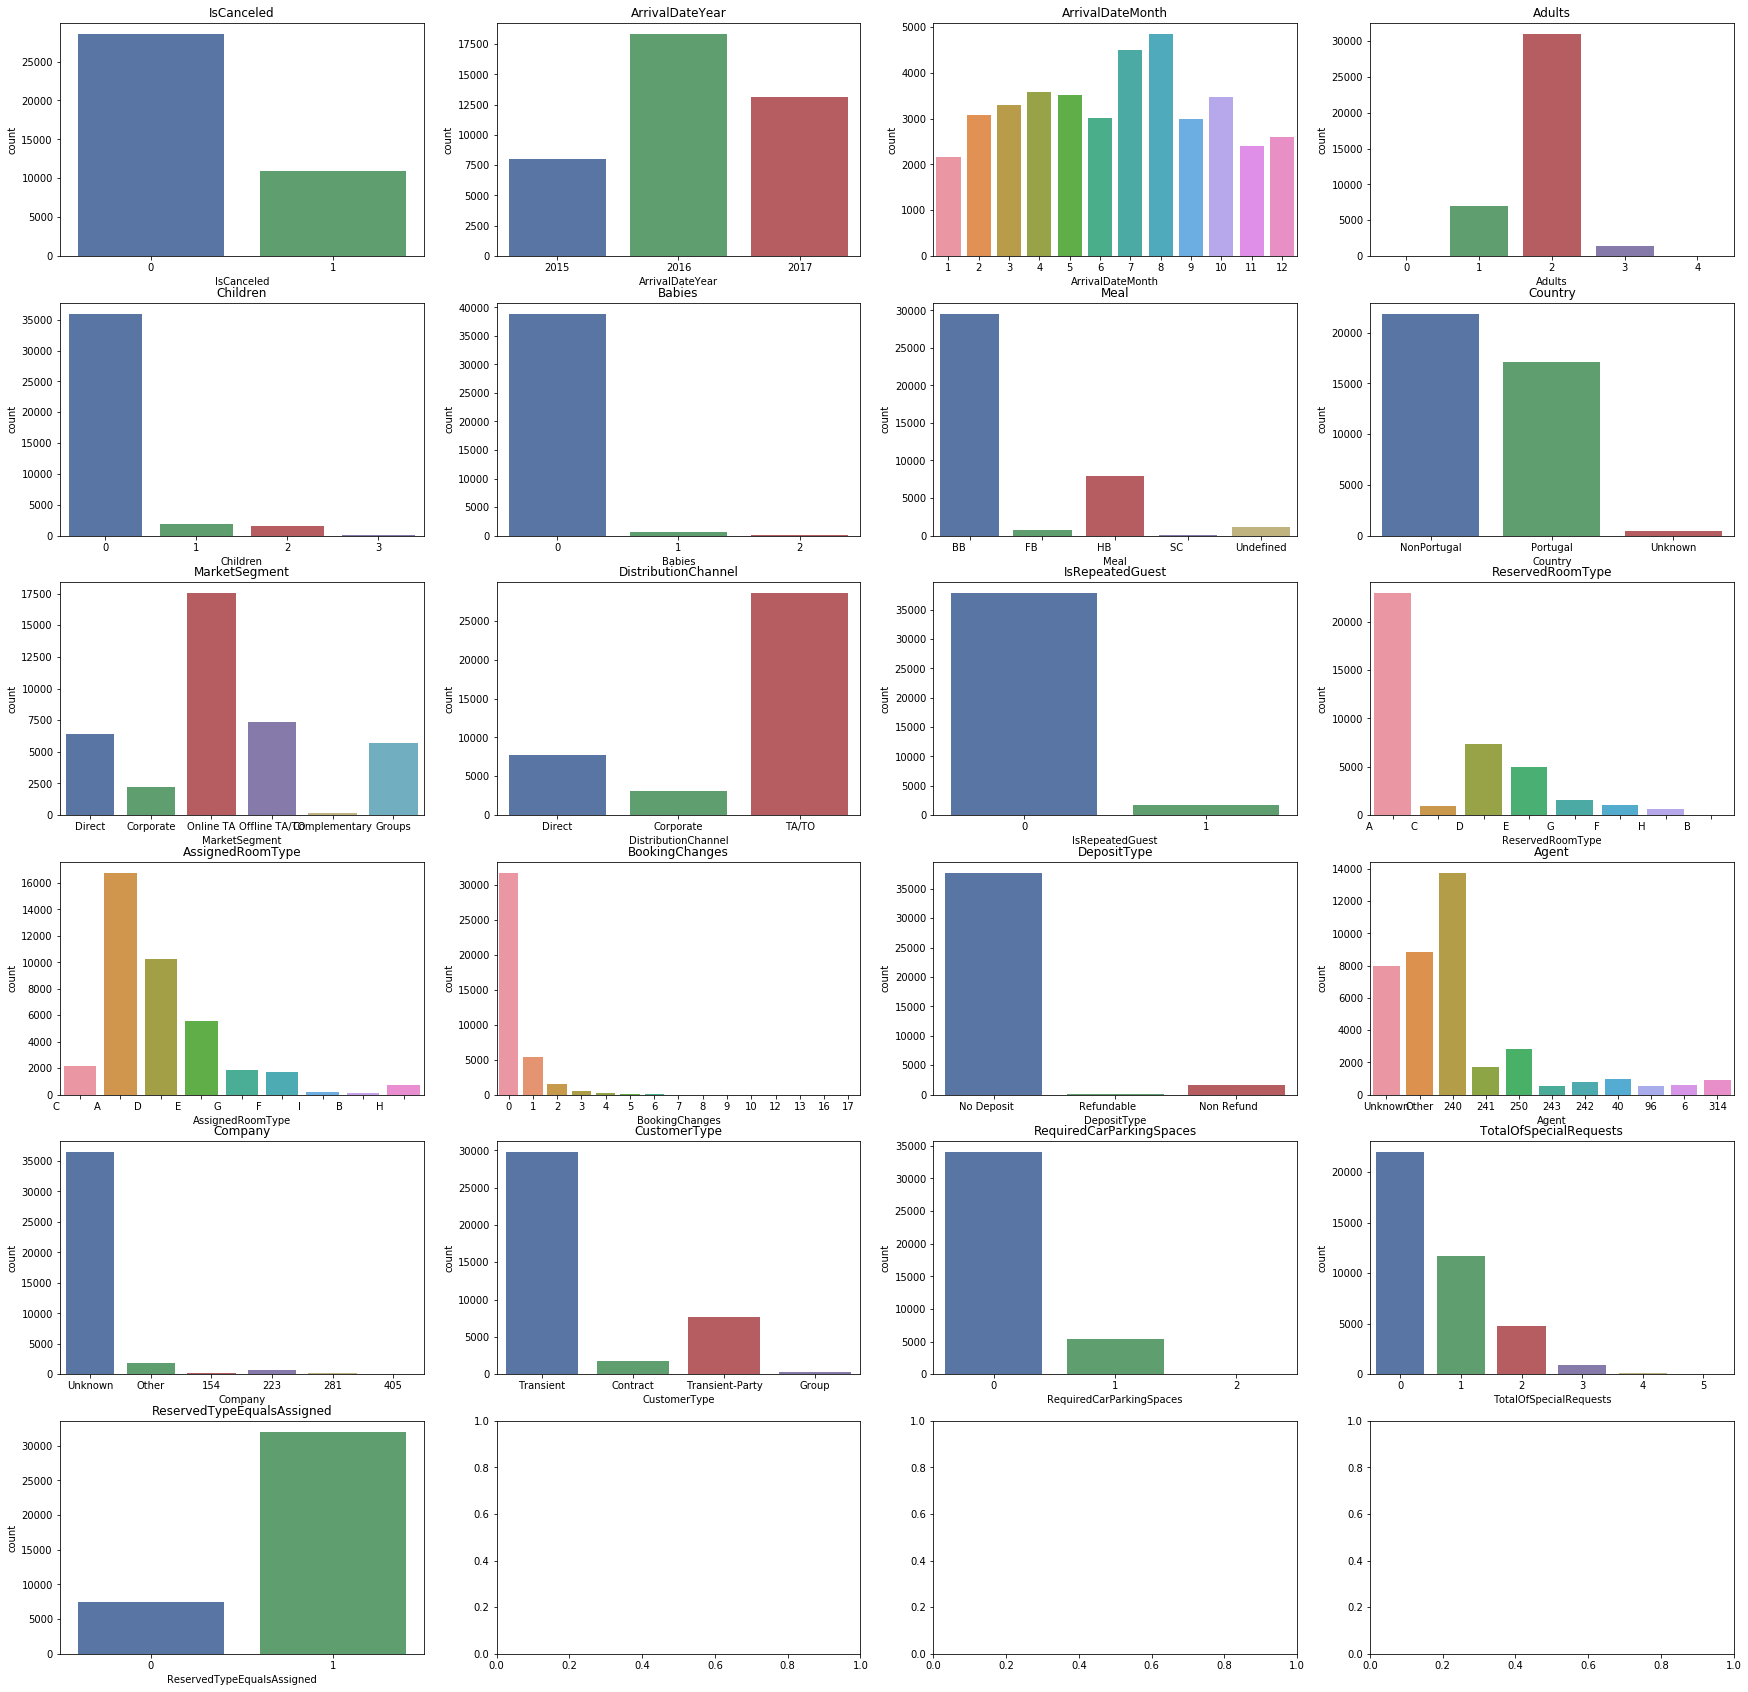

In [7]:
datacleaning_func.plot_dists(df, var_type = 'categorical')

Creating a cover chart with cancellations per month. 

In [4]:
year_month_cancellation_rate = []
year_month_total_reservation = []
year_month_total_cancellations = []
year_month_total_noncancellations = []
year_month_label = []

for year in range(2015, 2017 + 1):
    for month in range(1, 12 + 1):
        df_temp = df[df['ArrivalDateYear'] == year]
        df_temp = df_temp[df_temp['ArrivalDateMonth'] == month]
        
        total_rownum = len(df_temp)
        
        if total_rownum > 0:
            canceled_rownum = df_temp['IsCanceled'].sum()
            year_month_cancellation_rate.append(canceled_rownum / total_rownum * 100)
            year_month_total_reservation.append(total_rownum)
            year_month_total_cancellations.append(canceled_rownum)
            year_month_total_noncancellations.append(total_rownum - canceled_rownum)
            year_month_label.append(str(year) + " - " + str(month))

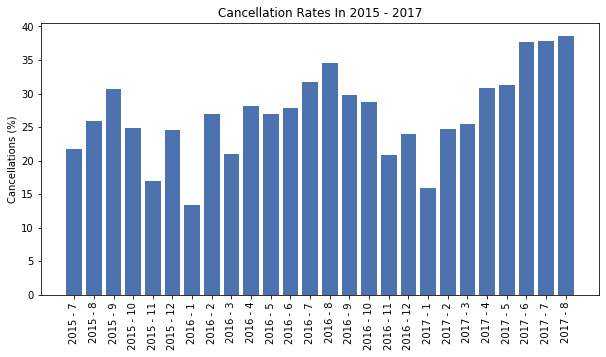

In [7]:
plt.figure(figsize = (10,5))
plt.bar(height = year_month_cancellation_rate, x = year_month_label)

plt.title("Cancellation Rates In 2015 - 2017")

plt.ylabel('Cancellations (%)')

plt.xticks( rotation = 90)

plt.show()


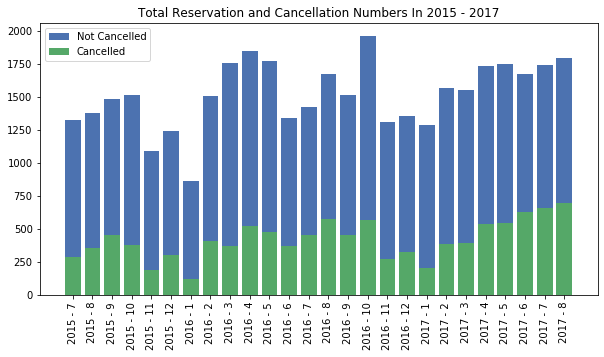

In [5]:
plt.figure(figsize = (10,5))
plt.bar(height = year_month_total_reservation, x = year_month_label, label = 'Not Cancelled')
plt.bar(height = year_month_total_cancellations, x = year_month_label, label = 'Cancelled')

plt.title("Total Reservation and Cancellation Numbers In 2015 - 2017")

plt.xticks( rotation = 90)

plt.legend()

plt.show()

In [16]:
df['IsCanceled'].sum() / len(df)

0.27670899551364914

In [17]:
df['LeadTime'].mean()

92.61789977948445